### This notebook analyzes pre-trained Bert-base models and their precomputed NTK (see Train_Bert_Seeded_9_Times)

You will need to fine tune Bert-base, then compute its NTK. We computed Bert's trace-NTK using a horrifically inefficient layerwise-based implementation that seperated each parameterized tensor into a seperate job. You can be much more efficient by computing the jacobian for all parameters in a single forward pass; and even better by projecting that Jacobian down using TRAK. 

see /scripts/BERT_NTK_oneGPU.py for how we calculated the trace-NTK exactly.

In [1]:
import numpy as np
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch import load
from torch.nn import functional as F
from torch import autograd

from torchvision import datasets

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import time
import sys
from pathlib import Path
import os
import gc



from einops import rearrange
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr

from utils2 import process_Cifar10

In [2]:
# because the dataset is int tsv format we have to use delimeter.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_sources', 'label', 'label_note', 'sentence'])

# creating a copy so we don't messed up our original dataset.
data=df.copy()
data.head(10)

,sentence_sources,label,label_note,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
5,gj04,1,NaN,I'll fix you a drink.
6,gj04,1,NaN,Fred watered the plants flat.
7,gj04,1,NaN,Bill coughed his way out of the restaurant.
8,gj04,1,NaN,We're dancing the night away.
9,gj04,1,NaN,Herman hammered the metal flat.


In [3]:
data.drop(['sentence_sources','label_note'],axis=1,inplace=True)
sentences=data.sentence.values
labels = data.label.values
data.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [4]:
from transformers import BertTokenizer
# using the low level BERT for our task.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Printing the original sentence.
print(' Original: ', sentences[0])

# Printing the tokenized sentence in form of list.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [5]:
input_ids = []
for sent in sentences:
    # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence which are encoding.
                        add_special_tokens = True, # Adding special tokens '[CLS]' and '[SEP]'

                         )
    
 
    input_ids.append(encoded_sent)

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

2023-09-13 17:23:46.064507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 17:23:49.141944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
attention_masks = []

for sent in input_ids:
    
    # Generating attention mask for sentences.
    #   - when there is 0 present as token id we are going to set mask as 0.
    #   - we are going to set mask 1 for all non-zero positive input id.
    att_mask = [int(token_id > 0) for token_id in sent]
    
   
    attention_masks.append(att_mask)

In [8]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=0)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,test_size=0.2, random_state=0)

In [9]:
#changing the numpy arrays into tensors for working on GPU. 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, shuffle=False)

In [10]:
NTK_seedless = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seedless.pt')).cpu().numpy()
NTK_seed1 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed1.pt')).cpu().numpy()
NTK_seed2 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed2.pt')).cpu().numpy()
NTK_seed3 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed3.pt')).cpu().numpy()

In [11]:
N_test_DATAPOINTS = len(NTK_seed1) - len(train_inputs)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs[0:N_test_DATAPOINTS], validation_masks[0:N_test_DATAPOINTS], validation_labels[0:N_test_DATAPOINTS])
validation_labels = validation_labels[0:N_test_DATAPOINTS]
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size, shuffle=False)

In [12]:
all_inputs = torch.cat([train_inputs,validation_inputs[0:N_test_DATAPOINTS]])
all_masks = torch.cat([train_masks,validation_masks[0:N_test_DATAPOINTS]])
all_labels = torch.cat([train_labels,validation_labels[0:N_test_DATAPOINTS]])

all_data = TensorDataset(all_inputs, all_masks, all_labels)
all_data_sampler = SequentialSampler(all_data)
all_dataloader = DataLoader(all_data, sampler=all_data_sampler, batch_size=1, shuffle=False)

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model3 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model_seedless = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)


ckpts = [torch.load('/rcfs/projects/task0_pmml/BERT/model_frozen.pt'),
        torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED1.pt'),
        torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED2.pt'),
        torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED3.pt')]

for ckpt in ckpts:
    ckpt.pop('bert.embeddings.position_ids')
        
model_seedless.load_state_dict(ckpts[0])
model1.load_state_dict(ckpts[1])
model2.load_state_dict(ckpts[2])
model3.load_state_dict(ckpts[3])
# Running the model on GPU.

model_seedless.to('cuda')
model1.to('cuda')
model2.to('cuda')
model3.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
def get_NN_outputs(model):
    Ys = []
    device='cuda'
    for step,batch in enumerate(validation_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        Ys.append(y.cpu().detach().numpy()) 
    NN_ys = np.concatenate(Ys)
    return NN_ys

def get_NN_outputs_train(model):
    Ys = []
    device='cuda'
    for step,batch in enumerate(train_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        Ys.append(y.cpu().detach().numpy()) 
    NN_ys = np.concatenate(Ys)
    return NN_ys

In [15]:
NNseedless_ys = get_NN_outputs(model_seedless)
NN1_ys = get_NN_outputs(model1)
NN2_ys = get_NN_outputs(model2)
NN3_ys = get_NN_outputs(model3)

NNseedless_pred = np.argmax(NNseedless_ys,axis=1)
NNseed1_pred = np.argmax(NN1_ys,axis=1)
NNseed2_pred = np.argmax(NN2_ys,axis=1)
NNseed3_pred = np.argmax(NN3_ys,axis=1)

confidences_seedless = np.array([NNseedless_ys[i,validation_labels[i].item()] for i in range(len(NNseedless_ys))])
confidences1 = np.array([NN1_ys[i,validation_labels[i].item()] for i in range(len(NN1_ys))])
confidences2 = np.array([NN2_ys[i,validation_labels[i].item()] for i in range(len(NN2_ys))])
confidences3 = np.array([NN3_ys[i,validation_labels[i].item()] for i in range(len(NN3_ys))])

In [16]:
test_accs = []
test_accs.append(((NNseedless_pred == validation_labels.cpu().numpy()).sum())/len(NNseedless_pred))
test_accs.append(((NNseed1_pred == validation_labels.cpu().numpy()).sum())/len(NNseedless_pred))
test_accs.append(((NNseed2_pred == validation_labels.cpu().numpy()).sum())/len(NNseedless_pred))
test_accs.append(((NNseed3_pred == validation_labels.cpu().numpy()).sum())/len(NNseedless_pred))

test_accs = np.array(test_accs)
NNtest_accs = test_accs
print('Test Accs: {:.4f} +/- {:.4f}'.format(test_accs.mean(),test_accs.std()/np.sqrt(len(test_accs))))

Test Accs: 0.8338 +/- 0.0008


In [17]:
from sklearn.linear_model import SGDClassifier
from joblib import dump, load

In [18]:
validation_labels

tensor([1, 1, 1,  ..., 1, 1, 0])

In [19]:
train_labels_regression = train_labels.detach().cpu().numpy().copy()
train_labels_regression[train_labels_regression==0] = 0

logit_performance  = []

def fit_and_scale(K0,K1):
    LogKernelRegression = SGDClassifier(loss='log_loss',penalty='l2',alpha=1e-2,fit_intercept=True,class_weight="balanced")
    LogKernelRegression.fit(K0,train_labels_regression)
    weights = LogKernelRegression.coef_
    intercept = LogKernelRegression.intercept_
    y = LogKernelRegression.predict_proba(K1)
    logit_performancethis = (LogKernelRegression.predict(K1)==validation_labels.cpu().numpy()[0:len(y)]).sum()/len(y)
    print(logit_performancethis)
    logit_performance.append(logit_performancethis)
    return weights, intercept, y



In [20]:
def Normalize(NTK,train_data_index=len(train_inputs)):
    K0 =NTK[0:train_data_index,0:train_data_index] #this is the train data gram matrix
    K1 = NTK[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
    K2 = NTK[train_data_index::,train_data_index::]

    K1 = K1 / (np.sqrt(np.diagonal(K0))[None,:]) / (np.sqrt(np.diagonal(K2))[:,None])
    K0 = K0 / np.sqrt(np.diagonal(K0))[None,:] / np.sqrt(np.diagonal(K0))[:,None]
    return K0, K1

def Extract(NTK,train_data_index=len(train_inputs)):
    K0 =NTK[0:train_data_index,0:train_data_index] #this is the train data gram matrix
    K1 = NTK[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
    
    K1 = K1 / K0.std()
    K0 = K0 / K0.std()
    return K0,K1



# Run ALL Above

## Load and extract NTK

### pNTK

In [21]:
K0_seedless, K1_seedless = Normalize(NTK_seedless)
K0_seed1, K1_seed1 = Normalize(NTK_seed1)
K0_seed2, K1_seed2 = Normalize(NTK_seed2)
K0_seed3, K1_seed3 = Normalize(NTK_seed3)

### pNTK0

In [22]:
K0_0seedless, K1_0seedless = Extract(NTK_seedless)
K0_0seed1, K1_0seed1 = Extract(NTK_seed1)
K0_0seed2, K1_0seed2 = Extract(NTK_seed2)
K0_0seed3, K1_0seed3 = Extract(NTK_seed3)

### CK

In [23]:
CK_list=[]
for item in ['seedless','seed1','seed2','seed3']:
    if item == 'seedless':
        path = f'/rcfs/projects/task0_pmml/BERT/testDDP_additivecomponents/classifier.weight-0.pt'
    else:
        path = f'/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_{item}/classifier.weight-0.pt'
    CK = torch.load(path,map_location='cuda')
    CK = torch.matmul(CK,CK.T)
    CK_list.append(CK.cpu())

CK_seedless = CK_list[0].cpu().numpy()[0:8192,0:8192]
CK_seed1 = CK_list[1].cpu().numpy()[0:8192,0:8192]
CK_seed2 = CK_list[2].cpu().numpy()[0:8192,0:8192]
CK_seed3 = CK_list[3].cpu().numpy()[0:8192,0:8192]
del CK_list

K0_CKseedless, K1_CKseedless = Normalize(CK_seedless)
K0_CKseed1, K1_CKseed1 = Normalize(CK_seed1)
K0_CKseed2, K1_CKseed2 = Normalize(CK_seed2)
K0_CKseed3, K1_CKseed3 = Normalize(CK_seed3)

### Embedding

In [24]:
Em_seedless = np.load(f'/rcfs/projects/task0_pmml/BERT/Em_kernels/seedless.npy')
Em_seed1 = np.load(f'/rcfs/projects/task0_pmml/BERT/Em_kernels/seed1.npy')
Em_seed2 = np.load(f'/rcfs/projects/task0_pmml/BERT/Em_kernels/seed2.npy')
Em_seed3 = np.load(f'/rcfs/projects/task0_pmml/BERT/Em_kernels/seed3.npy')


K0_Emseedless, K1_Emseedless = Normalize(Em_seedless)
K0_Emseed1, K1_Emseed1 = Normalize(Em_seed1)
K0_Emseed2, K1_Emseed2 = Normalize(Em_seed2)
K0_Emseed3, K1_Emseed3 = Normalize(Em_seed3)

### proj-trNTK

In [25]:
def load_proj_trNTK(i,path='/rcfs/projects/task0_pmml/proj_trNTK/BERT/BERT_trNTK'):
    trNTK=0
    for j in range(2):
        #I guess I used the wrong indices
        A = torch.from_numpy(np.load(f'{path}/{i}/grads_{j}.mmap'))[0:8192,:]
        trNTK+=torch.matmul(A,A.T)
    return trNTK.cpu().numpy()

proj_trNTK_seedless = load_proj_trNTK(0,)

In [26]:
def load_proj_trNTK(i,path='/rcfs/projects/task0_pmml/proj_trNTK/BERT/BERT_trNTK'):
    trNTK=0
    for j in range(2):
        #I guess I used the wrong indices
        A = torch.from_numpy(np.load(f'{path}/{i}/grads_{j}.mmap'))[0:8192,:]
        trNTK+=torch.matmul(A,A.T)
    return trNTK.cpu().numpy()

proj_trNTK_seedless = load_proj_trNTK(0,)
proj_trNTK_seed1 = load_proj_trNTK(1,)
proj_trNTK_seed2 = load_proj_trNTK(2,)
proj_trNTK_seed3 = load_proj_trNTK(3,)


K0_proj_trNTKseedless, K1_proj_trNTKseedless = Normalize(proj_trNTK_seedless)
K0_proj_trNTKseed1, K1_proj_trNTKseed1 = Normalize(proj_trNTK_seed1)
K0_proj_trNTKseed2, K1_proj_trNTKseed2 = Normalize(proj_trNTK_seed2)
K0_proj_trNTKseed3, K1_proj_trNTKseed3 = Normalize(proj_trNTK_seed3)

### Proj-pNTK

In [27]:
def load_proj_pNTK(i,path='/rcfs/projects/task0_pmml/proj_trNTK/BERT/BERT_pNTKtest/'):
    trNTK=0
    A = torch.from_numpy(np.load(f'{path}/{i}/grads.mmap'))[0:8192,:]
    trNTK+=torch.matmul(A,A.T)
    return trNTK.cpu().numpy()

proj_pNTK_seedless = load_proj_pNTK(0,)
proj_pNTK_seed1 = load_proj_pNTK(1,)
proj_pNTK_seed2 = load_proj_pNTK(2,)
proj_pNTK_seed3 = load_proj_pNTK(3,)


K0_proj_pNTKseedless, K1_proj_pNTKseedless = Normalize(proj_pNTK_seedless)
K0_proj_pNTKseed1, K1_proj_pNTKseed1 = Normalize(proj_pNTK_seed1)
K0_proj_pNTKseed2, K1_proj_pNTKseed2 = Normalize(proj_pNTK_seed2)
K0_proj_pNTKseed3, K1_proj_pNTKseed3 = Normalize(proj_pNTK_seed3)

### TraceIn

In [28]:
from tqdm import tqdm
lossfn = torch.nn.NLLLoss()
def Get_dL_dF(model,device='cuda'):
    all_dL_dF=[]
    for batch in tqdm(all_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        loss = lossfn(output,b_labels)
        grad = torch.autograd.grad(loss,output)[0]
        all_dL_dF.append(grad.cpu())
        
    return torch.cat(all_dL_dF)

def CalculateTraceIn(model,outer_path):
    
    dL_dF_seedless = Get_dL_dF(model)
    
    NTK_0 = 0
    NTK_1 = 0
    for path in tqdm(os.listdir(outer_path)):
        if '-0.pt' in path:
            NTK_0 += torch.load(outer_path+path,map_location='cpu')[0:8192,0:8192]
        if '-1.pt' in path:
            NTK_1 += torch.load(outer_path+path,map_location='cpu')[0:8192,0:8192]
        
    TraceIn = 0 
    i = 0
    TraceIn += dL_dF_seedless[:,i][:,None] * NTK_0[0:8192,0:8192] * dL_dF_seedless[:,i][None,:]
    i = 1
    TraceIn += dL_dF_seedless[:,i][:,None] * NTK_1[0:8192,0:8192]  * dL_dF_seedless[:,i][None,:]
    
    return TraceIn



In [29]:
# TraceIn_seedless = CalculateTraceIn(model_seedless,'/rcfs/projects/task0_pmml/BERT/testDDP_additivecomponents/')
# TraceIn_seed1 = CalculateTraceIn(model1,'/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed1/')
# TraceIn_seed2 = CalculateTraceIn(model2,'/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed2/')
# TraceIn_seed3 = CalculateTraceIn(model3,'/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed3/')

# np.save('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn_seedless.npy',TraceIn_seedless.cpu().numpy())
# np.save('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn1.npy',TraceIn_seed1.cpu().numpy())
# np.save('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn2.npy',TraceIn_seed2.cpu().numpy())
# np.save('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn3.npy',TraceIn_seed3.cpu().numpy())

In [30]:
TraceIn_seedless = np.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn_seedless.npy')
TraceIn_seed1 = np.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn1.npy')
TraceIn_seed2 = np.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn2.npy')
TraceIn_seed3 = np.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/TraceIn3.npy')

K0_TraceInseedless, K1_TraceInseedless = Normalize(TraceIn_seedless)
K0_TraceInseed1, K1_TraceInseed1 = Normalize(TraceIn_seed1)
K0_TraceInseed2, K1_TraceInseed2 = Normalize(TraceIn_seed2)
K0_TraceInseed3, K1_TraceInseed3 = Normalize(TraceIn_seed3)

# Compute GLMs

### pNTK

In [31]:
K1_seedless_weights, K1_seedless_intercept, y_seedless = fit_and_scale(K0_seedless,K1_seedless)
K1_seed1_weights, K1_seed1_intercept, y_seed1 = fit_and_scale(K0_seed1,K1_seed1)
K1_seed2_weights, K1_seed2_intercept, y_seed2 = fit_and_scale(K0_seed2,K1_seed2)
K1_seed3_weights, K1_seed3_intercept, y_seed3 = fit_and_scale(K0_seed3,K1_seed3)
#0.8409763313609467
#0.8335798816568047
#0.8372781065088757
#0.8276627218934911

0.8409763313609467
0.8328402366863905
0.834319526627219
0.8298816568047337


In [32]:
acc = np.array([
0.8394970414201184,
0.8365384615384616,
0.8357988165680473,
0.8284023668639053,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: 0.0013 +/- 0.0028


### pNTK0

In [33]:
K1_0seedless_weights, K1_0seedless_intercept, y_0seedless = fit_and_scale(K0_0seedless,K1_0seedless)
K1_0seed1_weights, K1_0seed1_intercept, y_0seed1 = fit_and_scale(K0_0seed1,K1_0seed1)
K1_0seed2_weights, K1_0seed2_intercept, y_0seed2 = fit_and_scale(K0_0seed2,K1_0seed2)
K1_0seed3_weights, K1_0seed3_intercept, y_0seed3 = fit_and_scale(K0_0seed3,K1_0seed3)
#0.8439349112426036
#0.8387573964497042
#0.8357988165680473
#0.8357988165680473

0.8424556213017751
0.8335798816568047
0.8365384615384616
0.841715976331361


In [34]:
acc = np.array([
0.8446745562130178,
0.8394970414201184,
0.8372781065088757,
0.8387573964497042,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: 0.0063 +/- 0.0018


### CK

In [35]:
K1_CKseedless_weights, K1_CKseedless_intercept, y_CKseedless = fit_and_scale(K0_CKseedless,K1_CKseedless)
K1_CKseed1_weights, K1_CKseed1_intercept, y_CKseed1 = fit_and_scale(K0_CKseed1,K1_CKseed1)
K1_CKseed2_weights, K1_CKseed2_intercept, y_CKseed2 = fit_and_scale(K0_CKseed2,K1_CKseed2)
K1_CKseed3_weights, K1_CKseed3_intercept, y_CKseed3 = fit_and_scale(K0_CKseed3,K1_CKseed3)
#0.8350591715976331
#0.8335798816568047
#0.8306213017751479
#0.8313609467455622

0.8335798816568047
0.834319526627219
0.8328402366863905
0.8298816568047337


In [36]:
acc = np.array([
0.8350591715976331,
0.8335798816568047,
0.8306213017751479,
0.8313609467455622,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: -0.0011 +/- 0.0014


### Embedding

In [37]:
K1_Emseedless_weights, K1_Emseedless_intercept, y_Emseedless = fit_and_scale(K0_Emseedless,K1_Emseedless)
K1_Emseed1_weights, K1_Emseed1_intercept, y_Emseed1 = fit_and_scale(K0_Emseed1,K1_Emseed1)
K1_Emseed2_weights, K1_Emseed2_intercept, y_Emseed2 = fit_and_scale(K0_Emseed2,K1_Emseed2)
K1_Emseed3_weights, K1_Emseed3_intercept, y_Emseed3 = fit_and_scale(K0_Emseed3,K1_Emseed3)
#0.8328402366863905
#0.8394970414201184
#0.834319526627219
#0.8180473372781065

0.8313609467455622
0.8409763313609467
0.8357988165680473
0.8394970414201184


In [38]:
acc = np.array([
0.8328402366863905,
0.8394970414201184,
0.834319526627219,
0.8180473372781065,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: -0.0026 +/- 0.0048


### Proj-trNTK

In [39]:
K1_proj_trNTKseedless_weights, K1_proj_trNTKseedless_intercept, y_proj_trNTKseedless = fit_and_scale(K0_proj_trNTKseedless,K1_proj_trNTKseedless)
K1_proj_trNTKseed1_weights, K1_proj_trNTKseed1_intercept, y_proj_trNTKseed1 = fit_and_scale(K0_proj_trNTKseed1,K1_proj_trNTKseed1)
K1_proj_trNTKseed2_weights, K1_proj_trNTKseed2_intercept, y_proj_trNTKseed2 = fit_and_scale(K0_proj_trNTKseed2,K1_proj_trNTKseed2)
K1_proj_trNTKseed3_weights, K1_proj_trNTKseed3_intercept, y_proj_trNTKseed3 = fit_and_scale(K0_proj_trNTKseed3,K1_proj_trNTKseed3)

0.8372781065088757
0.8357988165680473
0.8357988165680473
0.834319526627219


In [40]:
acc = np.array([
0.8394970414201184,
0.8328402366863905,
0.8321005917159763,
0.8284023668639053,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: -0.0006 +/- 0.0026


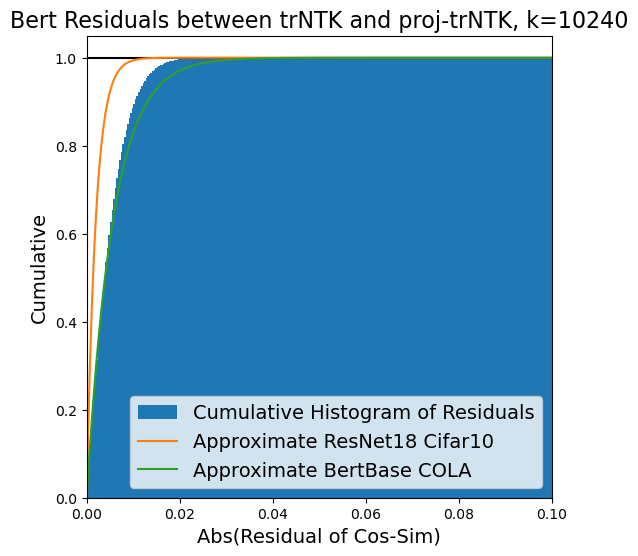

In [41]:
residuals = (K0_proj_trNTKseed3 - K0_seed3).flatten()

fig = plt.figure(figsize=(6,6))
plt.hist(np.abs(residuals),bins=np.linspace(0,0.10,300),cumulative=True,density=True,label='Cumulative Histogram of Residuals')
#plt.yscale('log')
plt.title(f'Bert Residuals between trNTK and proj-trNTK, k={512*20}',fontsize=16)
plt.ylabel('Cumulative',fontsize=14)
plt.xlabel('Abs(Residual of Cos-Sim)',fontsize=14)
plt.xlim(0,0.10)
k=512*20
x = np.linspace(0,0.1,300)
y = 1 - np.exp(-x*k/20)
plt.hlines(1.0,0.0,0.1,color='k')
plt.plot(x,y,label='Approximate ResNet18 Cifar10')

y = 1 - np.exp(-x*k/58)
plt.plot(x,y,label='Approximate BertBase COLA')
plt.legend(loc='lower right',fontsize=14)

#plt.savefig('/rcfs/projects/task0_pmml/images/residuals_bert_base_seed3.png')

plt.show()
#This is exponential, because the histogram looks like a line on both sides logarithmically scaled.

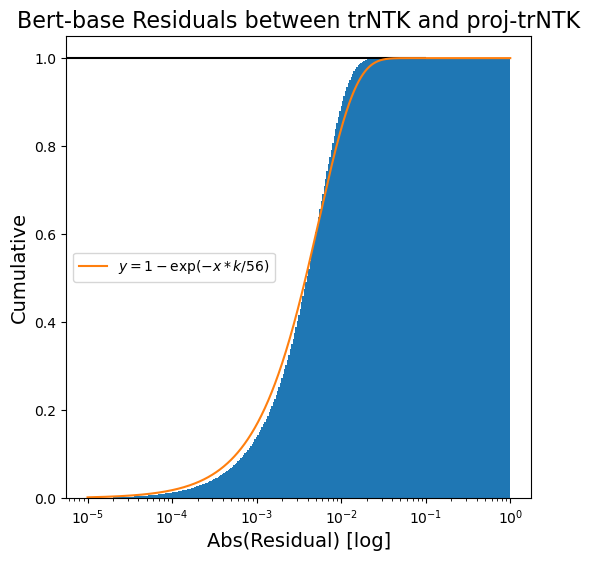

In [63]:
residuals = (K0_proj_trNTKseed3 - K0_seed3).flatten()

fig = plt.figure(figsize=(6,6))
plt.hist(np.abs(residuals),bins=np.logspace(-5,0,300),cumulative=True,density=True,)
#plt.yscale('log')
plt.title('Bert-base Residuals between trNTK and proj-trNTK',fontsize=16)
plt.ylabel('Cumulative',fontsize=14)
plt.xlabel('Abs(Residual) [log]',fontsize=14)

k=10_240
x = np.logspace(-5,0,1000)
k=10_240
a=56
y = 1 - np.exp(-x*k/a)
plt.hlines(1.0,0.0,0.1,color='k')
plt.xscale('log')
#plt.xlim(0,1)
plt.plot(x,y,label=r'$y = 1 - \exp(-x*k/56)$')
plt.legend(loc='center left')
plt.savefig('/rcfs/projects/task0_pmml/images/residuals_bert_base_seed3.png')
plt.show()
#This is exponential, because the histogram looks like a line on both sides logarithmically scaled.

### proj-pNTK

In [73]:
K1_proj_pNTKseedless_weights, K1_proj_pNTKseedless_intercept, y_proj_pNTKseedless = fit_and_scale(K0_proj_pNTKseedless,K1_proj_pNTKseedless)
K1_proj_pNTKseed1_weights, K1_proj_pNTKseed1_intercept, y_proj_pNTKseed1 = fit_and_scale(K0_proj_pNTKseed1,K1_proj_pNTKseed1)
K1_proj_pNTKseed2_weights, K1_proj_pNTKseed2_intercept, y_proj_pNTKseed2 = fit_and_scale(K0_proj_pNTKseed2,K1_proj_pNTKseed2)
K1_proj_pNTKseed3_weights, K1_proj_pNTKseed3_intercept, y_proj_pNTKseed3 = fit_and_scale(K0_proj_pNTKseed3,K1_proj_pNTKseed3)

0.841715976331361
0.8402366863905325
0.8335798816568047
0.8402366863905325


In [148]:
acc = np.array([
0.841715976331361,
0.8402366863905325,
0.8335798816568047,
0.8402366863905325,
])
diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: 0.0052 +/- 0.0016


### TraceIn

In [77]:
K1_TraceInseedless_weights, K1_TraceInseedless_intercept, y_TraceInseedless = fit_and_scale(K0_TraceInseedless,K1_TraceInseedless)
K1_TraceInseed1_weights, K1_TraceInseed1_intercept, y_TraceInseed1 = fit_and_scale(K0_TraceInseed1,K1_TraceInseed1)
K1_TraceInseed2_weights, K1_TraceInseed2_intercept, y_TraceInseed2 = fit_and_scale(K0_TraceInseed2,K1_TraceInseed2)
K1_TraceInseed3_weights, K1_TraceInseed3_intercept, y_TraceInseed3 = fit_and_scale(K0_TraceInseed3,K1_TraceInseed3)
#0.8831360946745562
#0.8809171597633136
#0.8594674556213018
#0.9031065088757396

0.8816568047337278
0.882396449704142
0.856508875739645
0.8979289940828402


In [149]:
acc = np.array([
0.8831360946745562,
0.8846153846153846,
0.8572485207100592,
0.908284023668639,
])

diff = (acc - NNtest_accs)


print('TAD: {:.4f} +/- {:.4f}'.format(diff.mean(),diff.std()/2))

TAD: 0.0496 +/- 0.0084


# Now Compute Taus

In [102]:
def numpy_softmax(x):
    return np.exp(x) / np.sum(np.exp(x),axis=1)[:,None]

def sigmoid(p):
    return 1/(1+np.exp(-p))

def logit(p,eps=0.0):
    return np.log((p+eps)/(1-p+eps))

def softmax_numpy(x):
    return np.exp(x) / np.sum(np.exp(x))

test_y = validation_labels

def tau_comparison_final(X,Y):    
    
    correct_logit_mask = test_y.cpu().numpy().astype(int)
    
    if isinstance(X,torch.Tensor):
        X = X.detach().cpu().numpy()
    if isinstance(Y,torch.Tensor):
        Y = Y.detach().cpu().numpy()
    
    #And because we are doing binary the SGDClassifier has corrected to using one ouput.
    #X = np.array(X)
    X = sigmoid(np.array(X))
    
    #In this case the Ys are already softmax scaled.
    #if we downselect onto the first neuron we can still do our comparison
    Y = Y[:,1]
    
    mask = np.logical_or(np.logical_or(X==1,Y==1),np.logical_or(X==0,Y==0))

    X = X[~mask]
    Y = Y[~mask]
    
#     plt.plot(X,Y,'.')
#     plt.show()
    
    Tau = kendalltau(X,Y).correlation
    return Tau

### trNTK

In [119]:
K1_seedless_scaled = np.sum((K1_seedless * K1_seedless_weights),axis=1) + K1_seedless_intercept
K1_seed1_scaled = np.sum(K1_seed1 * K1_seed1_weights,axis=1) + K1_seed1_intercept
K1_seed2_scaled = np.sum(K1_seed2 * K1_seed2_weights,axis=1) + K1_seed2_intercept
K1_seed3_scaled = np.sum(K1_seed3 * K1_seed3_weights,axis=1) + K1_seed3_intercept

In [121]:
Taus = []

t = tau_comparison_final(K1_seedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_seed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_seed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_seed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#au: 0.8085 +/- 0.0169
# 0.809(9)

Tau: 0.8085 +/- 0.0085


### trNTK0

In [122]:
K1_0seedless_scaled = np.sum((K1_0seedless * K1_0seedless_weights),axis=1) + K1_0seedless_intercept
K1_0seed1_scaled = np.sum(K1_0seed1 * K1_0seed1_weights,axis=1) + K1_0seed1_intercept
K1_0seed2_scaled = np.sum(K1_0seed2 * K1_0seed2_weights,axis=1) + K1_0seed2_intercept
K1_0seed3_scaled = np.sum(K1_0seed3 * K1_0seed3_weights,axis=1) + K1_0seed3_intercept

In [123]:
Taus = []

t = tau_comparison_final(K1_0seedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_0seed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_0seed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_0seed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#Tau: 0.5260 +/- 0.1065
#Tau: 0.5(1)

Tau: 0.5260 +/- 0.1065


### CK

In [124]:
K1_CKseedless_scaled = np.sum((K1_CKseedless * K1_CKseedless_weights),axis=1) + K1_CKseedless_intercept
K1_CKseed1_scaled = np.sum(K1_CKseed1 * K1_CKseed1_weights,axis=1) + K1_CKseed1_intercept
K1_CKseed2_scaled = np.sum(K1_CKseed2 * K1_CKseed2_weights,axis=1) + K1_CKseed2_intercept
K1_CKseed3_scaled = np.sum(K1_CKseed3 * K1_CKseed3_weights,axis=1) + K1_CKseed3_intercept

In [125]:
Taus = []

t = tau_comparison_final(K1_CKseedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_CKseed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_CKseed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_CKseed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#0.52(4)

Tau: 0.5169 +/- 0.0437


### Embedding

In [126]:
K1_Emseedless_scaled = np.sum((K1_Emseedless * K1_Emseedless_weights),axis=1) + K1_Emseedless_intercept
K1_Emseed1_scaled = np.sum(K1_Emseed1 * K1_Emseed1_weights,axis=1) + K1_Emseed1_intercept
K1_Emseed2_scaled = np.sum(K1_Emseed2 * K1_Emseed2_weights,axis=1) + K1_Emseed2_intercept
K1_Emseed3_scaled = np.sum(K1_Emseed3 * K1_Emseed3_weights,axis=1) + K1_Emseed3_intercept

In [127]:
Taus = []

t = tau_comparison_final(K1_Emseedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_Emseed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_Emseed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_Emseed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#0.65(2)

Tau: 0.6463 +/- 0.0224


### proj-trNTK

In [128]:
K1_proj_trNTKseedless_scaled = np.sum((K1_proj_trNTKseedless * K1_proj_trNTKseedless_weights),axis=1) + K1_proj_trNTKseedless_intercept
K1_proj_trNTKseed1_scaled = np.sum((K1_proj_trNTKseed1 * K1_proj_trNTKseed1_weights),axis=1) + K1_proj_trNTKseed1_intercept
K1_proj_trNTKseed2_scaled = np.sum((K1_proj_trNTKseed2 * K1_proj_trNTKseed2_weights),axis=1) + K1_proj_trNTKseed2_intercept
K1_proj_trNTKseed3_scaled = np.sum((K1_proj_trNTKseed3 * K1_proj_trNTKseed3_weights),axis=1) + K1_proj_trNTKseed3_intercept

In [129]:
Taus = []

t = tau_comparison_final(K1_proj_trNTKseedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_trNTKseed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_trNTKseed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_trNTKseed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#0.800(9)

Tau: 0.7997 +/- 0.0087


# proj-pNTK

In [131]:
K1_proj_pNTKseedless_scaled = np.sum((K1_proj_pNTKseedless * K1_proj_pNTKseedless_weights),axis=1) + K1_proj_pNTKseedless_intercept
K1_proj_pNTKseed1_scaled = np.sum((K1_proj_pNTKseed1 * K1_proj_pNTKseed1_weights),axis=1) + K1_proj_pNTKseed1_intercept
K1_proj_pNTKseed2_scaled = np.sum((K1_proj_pNTKseed2 * K1_proj_pNTKseed2_weights),axis=1) + K1_proj_pNTKseed2_intercept
K1_proj_pNTKseed3_scaled = np.sum((K1_proj_pNTKseed3 * K1_proj_pNTKseed3_weights),axis=1) + K1_proj_pNTKseed3_intercept

In [132]:
Taus = []

t = tau_comparison_final(K1_proj_pNTKseedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_pNTKseed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_pNTKseed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_proj_pNTKseed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#0.72(2)

Tau: 0.7155 +/- 0.0229


### Grad-Cos

In [133]:
K1_TraceInseedless_scaled = np.sum((K1_TraceInseedless * K1_TraceInseedless_weights),axis=1) + K1_TraceInseedless_intercept
K1_TraceInseed1_scaled = np.sum(K1_TraceInseed1 * K1_TraceInseed1_weights,axis=1) + K1_TraceInseed1_intercept
K1_TraceInseed2_scaled = np.sum(K1_TraceInseed2 * K1_TraceInseed2_weights,axis=1) + K1_TraceInseed2_intercept
K1_TraceInseed3_scaled = np.sum(K1_TraceInseed3 * K1_TraceInseed3_weights,axis=1) + K1_TraceInseed3_intercept

In [134]:
Taus = []

t = tau_comparison_final(K1_TraceInseedless_scaled,NNseedless_ys)
Taus.append(t)
t = tau_comparison_final(K1_TraceInseed1_scaled,NN1_ys)
Taus.append(t)
t = tau_comparison_final(K1_TraceInseed2_scaled,NN2_ys)
Taus.append(t)
t = tau_comparison_final(K1_TraceInseed3_scaled,NN3_ys)
Taus.append(t)

Taus = np.array(Taus)

print("Tau: {:.4f} +/- {:.4f}".format(Taus.mean(),Taus.std()/2))
#Tau: 0.74(1)

Tau: 0.7378 +/- 0.0107
